In [1]:
import matplotlib.pyplot as plt
import numpy as np
import abc

<img alt='task' src='pics/task.png' width='600'>

In [2]:
class Scheme_abs(metaclass=abc.ABCMeta):
    """
    Computational scheme abstract class.
    """

    def __init__(self, c, h, tau, X, T, phi_t, psi_x):
        """
        Initialize scheme with desired parameters.
        phi_t - t boundary conditions
        psi_x - x boundary conditions
        """
        self._c   = c   # coeff in equation
        self._h   = h   # x-coord step
        self._tau = tau # time step
        self._X   = X   # max x-coord value
        self._T   = T   # max t-coord value

        self._x_points_num = int(self._X / self._h)
        self._t_points_num = int(self._T / self._tau)
        
        self.data = np.zeros((self._t_points_num, self._x_points_num))

        self.__init_time_boundary(phi_t)
        self.__init_x_coord_boundary(psi_x)
    
    def __init_time_boundary(self, phi_t):
        """
        Initialize t boundary.
        """
        for t_idx in range(self._t_points_num):
            self.data[0,t_idx] = phi_t(self._tau * t_idx)
    
    def __init_x_coord_boundary(self, psi_x):
        """
        Initialize x boundary.
        """
        for x_idx in range(self._x_points_num):
            self.data[x_idx, 0] = psi_x(self._h * x_idx)
    
    @abc.abstractmethod
    def compute(self):
        """
        Main computational method.
        """
        pass

    @abc.abstractmethod
    def name(self) -> str:
        pass
    
    def plot(self):
        """
        Plot results.
        """
        plt.figure(figsize=[7,7])

        t = np.arange(0, self._T, self._tau)
        x = np.arange(0, self._X, self._h)

        plt.xticks(np.arange(0, self._T, self._T / 10))
        plt.yticks(np.arange(0, self._X, self._X / 10))

        plt.xlabel("t")
        plt.ylabel("x")
        
        plt.title(f"{self.name()}: h={self._h} tau={self._tau}")

        plt.pcolormesh(t, x, np.abs(self.data), cmap='plasma')

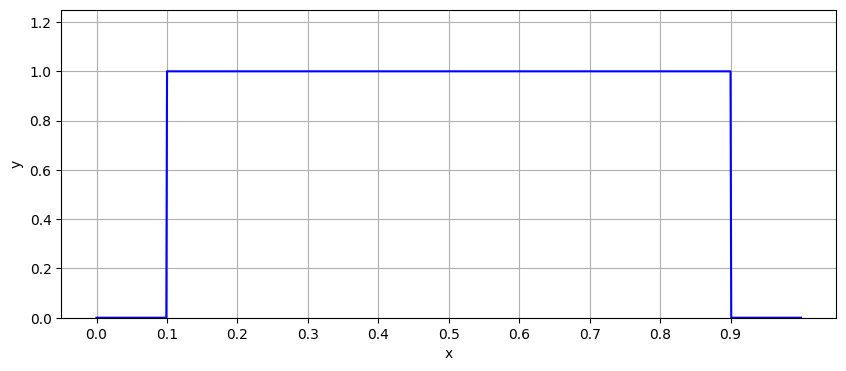

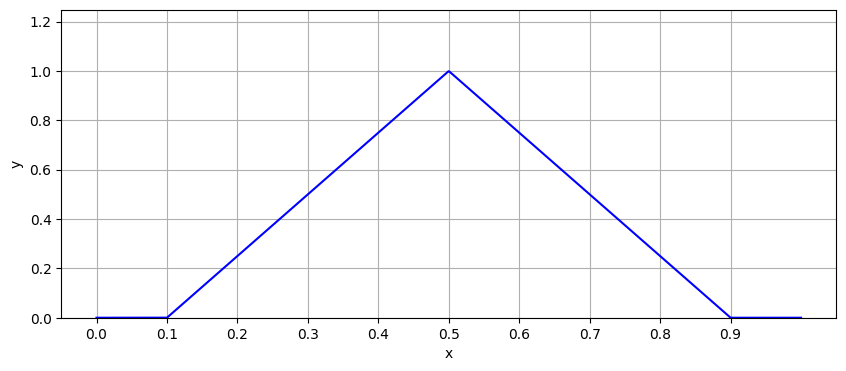

In [3]:
def square_pulse(x, magn=1.0, left=0.1, right=0.9):
    """
    Square pulse for boundaries.
    """
    if x < left or x  > right: return 0
    else: return magn

def triangular_pulse(x, magn=1.0, left=0.1, right=0.9):
    """
    Triangular pulse for boundaries.
    """
    if x < left or x > right:
        return 0

    med   = (right + left) / 2
    width = (right - left) / 2
    
    return magn * (1 - abs(med - x) / width)

def plot_func(func, min = 0.0, max = 1.0, step = 0.001, plot_step = 0.1):
    """
    Plot function to check boundaries
    """

    points_num = int((max - min) / step)

    x = np.linspace(min, max, points_num)
    y = np.array([func(x_i) for x_i in x])

    plt.figure(figsize=[10, 4])
    
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')

    plt.xticks(np.arange(min, max, plot_step))
    plt.ylim(0, np.max(y) * 1.25)
    plt.plot(x, y, 'b-')

plot_func(square_pulse)
plot_func(triangular_pulse)

<img alt='kir' src='pics/kir.png' width='600'>

In [4]:
class Scheme_KIR(Scheme_abs):
    def __init__(self, c, h, tau, X, T, phi_t, psi_x):
        super().__init__(c, h, tau, X, T, phi_t, psi_x)

    def name(self) -> str:
        return "KIR"
    
    def compute(self):
        if self._c > 0: self.__compute_pos_coeff()
        else: raise ValueError("c<0 is not supported")
    
    def __compute_pos_coeff(self):
        data = self.data
        
        for t_idx in range(1, self._t_points_num):
            for x_idx in range(1, self._x_points_num):

                diff = (data[t_idx-1,x_idx] - data[t_idx-1,x_idx-1]) / self._h
                val = data[t_idx-1,x_idx] - self._c * self._tau * diff
                
                self.data[t_idx,x_idx] = val

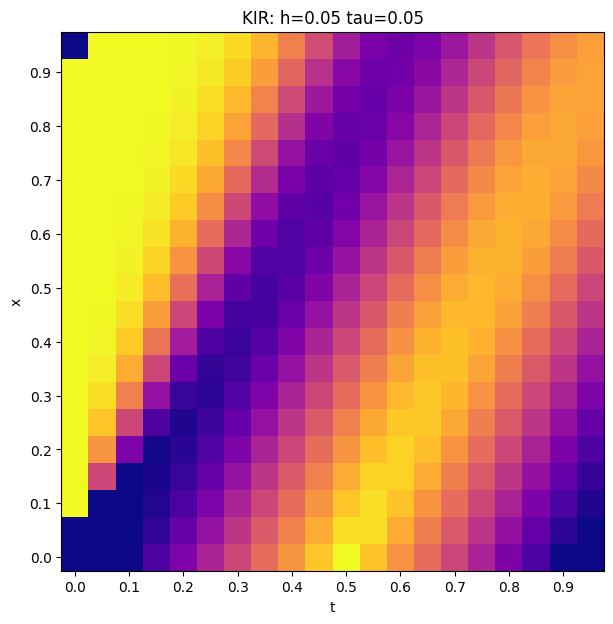

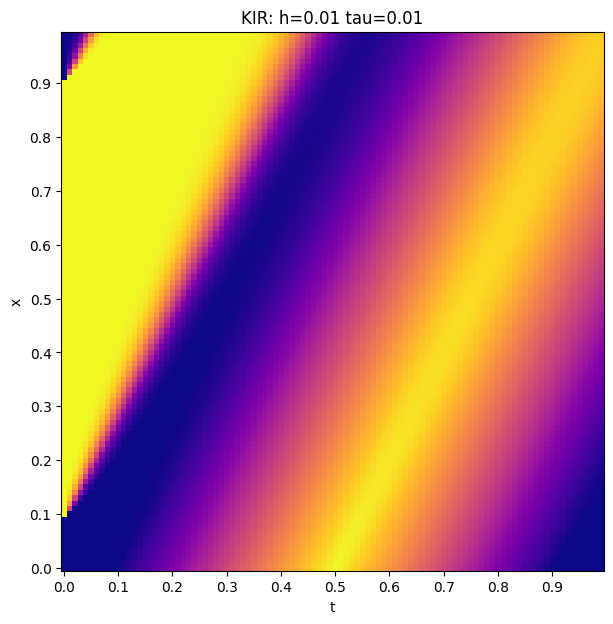

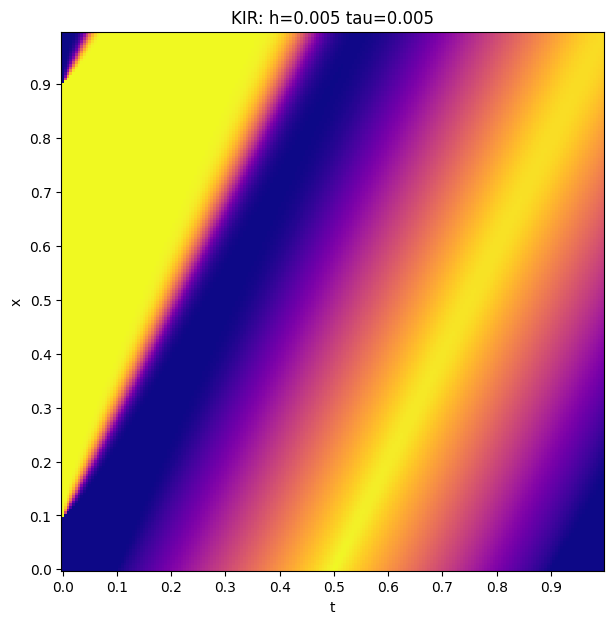

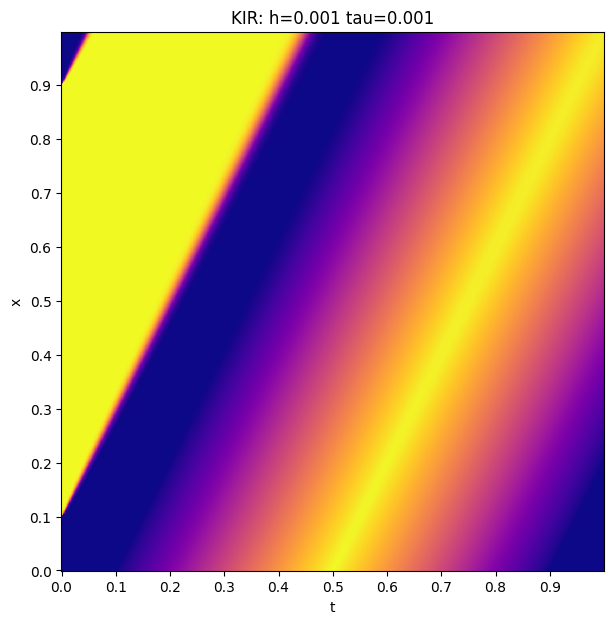

In [5]:
h_k   = [0.05, 0.01, 0.005, 0.001]

for i in range(len(h_k)):
    scheme_kir = Scheme_KIR(
        c = 0.5, 
        h = h_k[i], 
        tau = h_k[i], 
        X = 1.0,
        T = 1.0,
        phi_t = triangular_pulse,
        psi_x = square_pulse
    )
    
    scheme_kir.compute()
    scheme_kir.plot()

<img alt='maccormack' src='pics/maccormack.png' width='600'>

In [6]:
class Scheme_MacCormack(Scheme_abs):
    def __init__(self, c, h, tau, X, T, phi_t, psi_x):
        super().__init__(c, h, tau, X, T, phi_t, psi_x)

    def name(self) -> str:
        return "MacCormack"
    
    def compute(self):
        data = self.data
        
        for t_idx in range(1, self._t_points_num):
            for x_idx in range(1, self._x_points_num):

                # Boundary point - simple 'angle' scheme
                if x_idx == self._x_points_num - 1:
                    diff = (data[t_idx-1,x_idx] - data[t_idx-1,x_idx-1]) / self._h
                    val = data[t_idx-1,x_idx] - self._c * self._tau * diff
                    
                    self.data[t_idx,x_idx] = val
                    
                    continue

                # Step 1st: 'Predictor'
                diff = (data[t_idx-1,x_idx+1] - data[t_idx-1,x_idx]) / self._h
                u_m = data[t_idx-1,x_idx] - self._c * self._tau * diff

                diff = (data[t_idx-1,x_idx] - data[t_idx-1,x_idx-1]) / self._h
                u_m_1 = data[t_idx-1,x_idx-1] - self._c * self._tau * diff

                # Step 2nd: 'Corrector'
                diff = (u_m - u_m_1) / (2 * self._h)
                val = 0.5 * (data[t_idx-1,x_idx] + u_m) - self._c * self._tau * diff
                
                self.data[t_idx,x_idx] = val

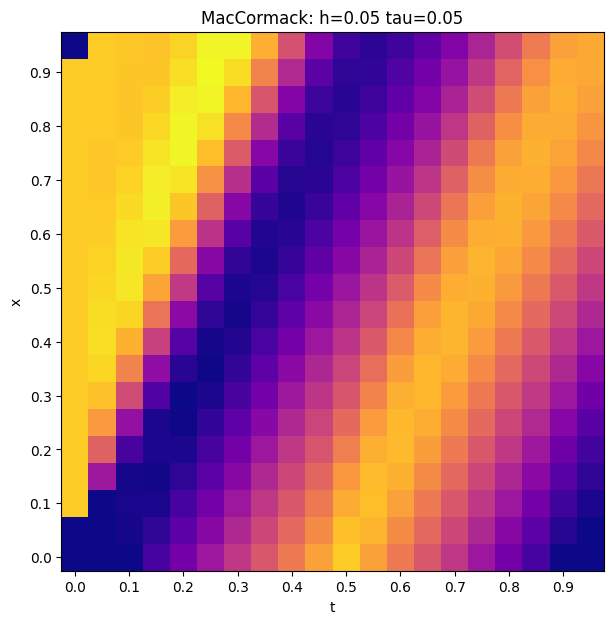

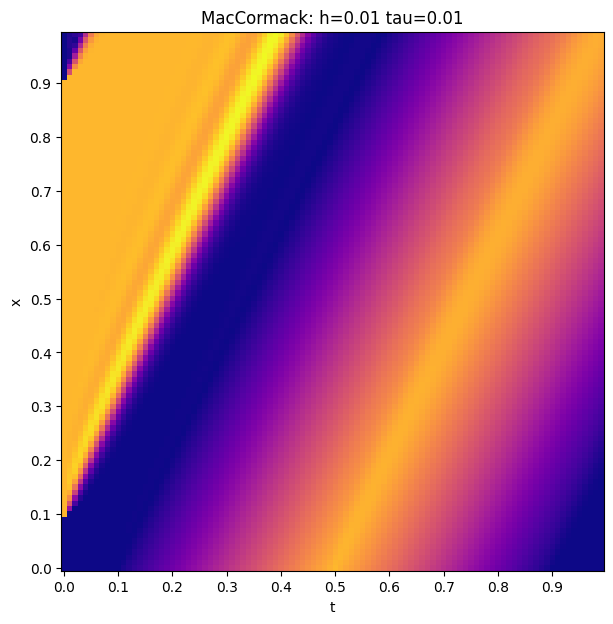

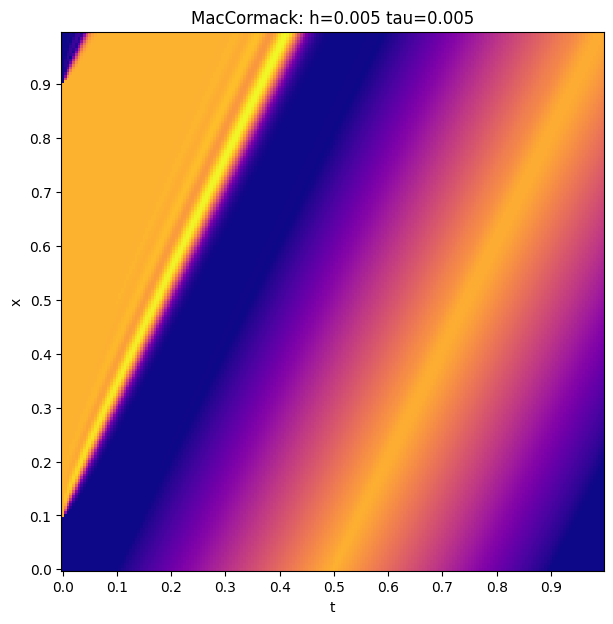

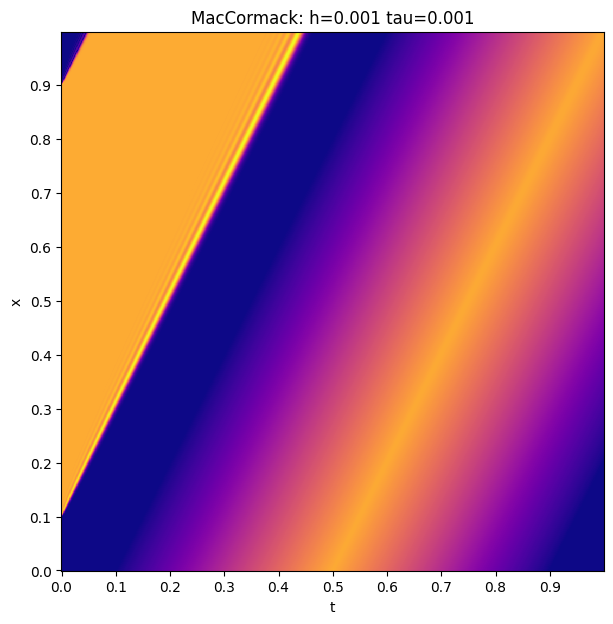

In [7]:
for i in range(len(h_k)):
    scheme_kir = Scheme_MacCormack(
        c = 0.5, 
        h = h_k[i], 
        tau = h_k[i], 
        X = 1.0,
        T = 1.0,
        phi_t = triangular_pulse,
        psi_x = square_pulse
    )
    
    scheme_kir.compute()
    scheme_kir.plot()

<img alt='fed1' src='pics/fed1.png' width='600'>
<img alt='fed2' src='pics/fed2.png' width='600'>

In [8]:
class Scheme_Fedorenko(Scheme_abs):
    def __init__(self, c, h, tau, X, T, phi_t, psi_x):
        super().__init__(c, h, tau, X, T, phi_t, psi_x)

    def name(self) -> str:
        return "Fedorenko"
    
    def compute(self):
        data = self.data
        
        for t_idx in range(1, self._t_points_num):
            for x_idx in range(1, self._x_points_num):

                # Boundary point - simple 'angle' scheme
                if x_idx == self._x_points_num - 1:
                    diff = (data[t_idx-1,x_idx] - data[t_idx-1,x_idx-1]) / self._h
                    val = data[t_idx-1,x_idx] - self._c * self._tau * diff
                    
                    self.data[t_idx,x_idx] = val
                    
                    continue
                    
                frac = self._c * self._tau / self._h
                    
                diff = data[t_idx-1,x_idx] - data[t_idx-1,x_idx-1]
                term1 = frac * diff

                diff = data[t_idx-1,x_idx-1] - 2 * data[t_idx-1,x_idx] + data[t_idx-1,x_idx+1]
                term2 = 0.5 * frac * (1 - frac) * diff

                self.data[t_idx,x_idx] = data[t_idx-1, x_idx] - term1 - term2

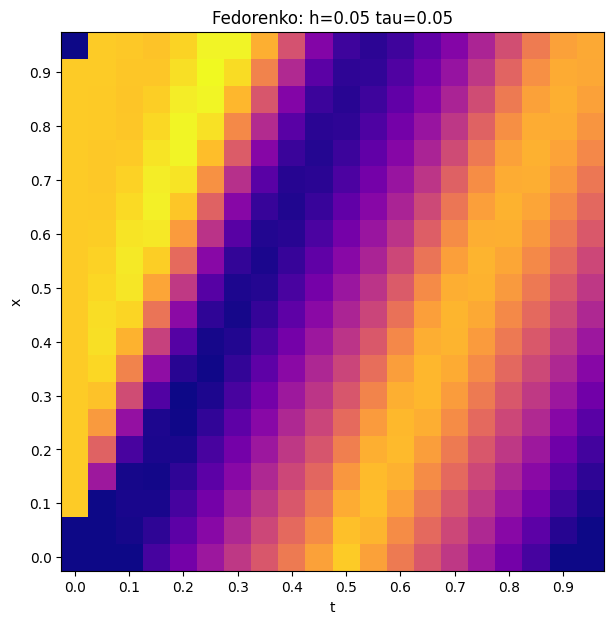

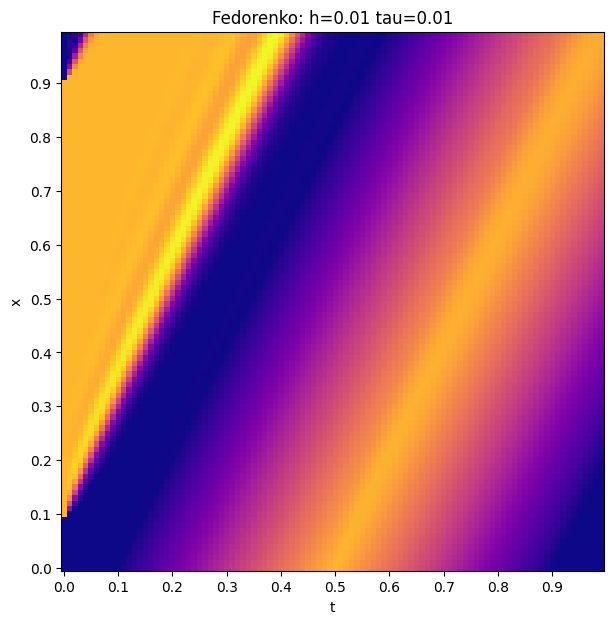

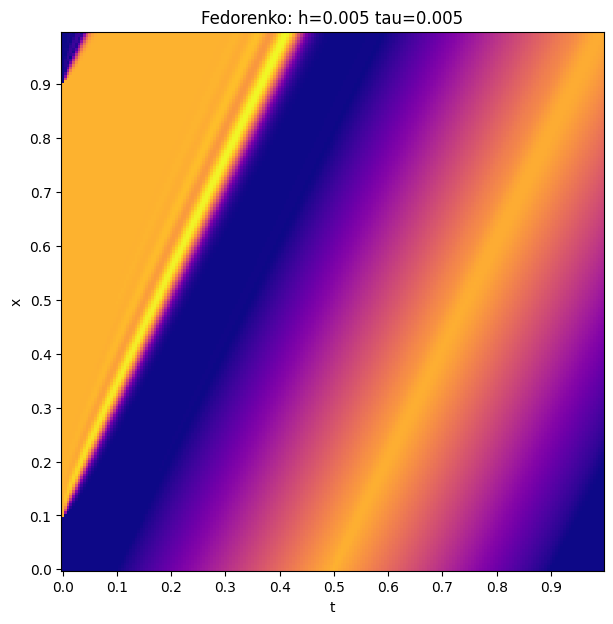

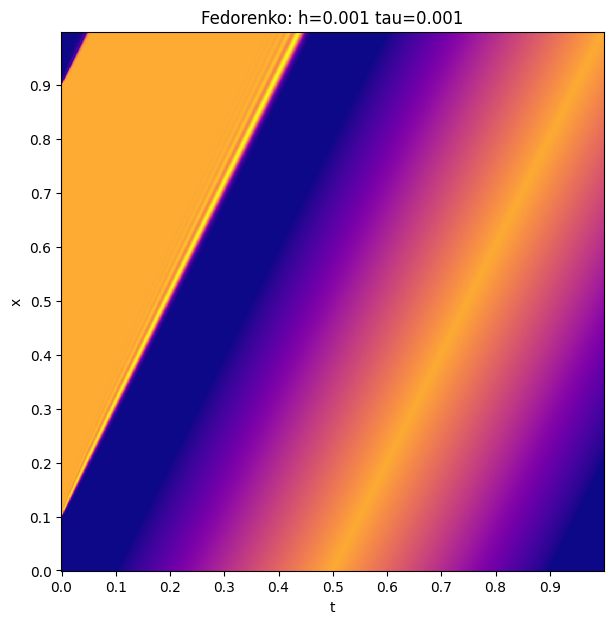

In [9]:
for i in range(len(h_k)):
    scheme_kir = Scheme_Fedorenko(
        c = 0.5, 
        h = h_k[i], 
        tau = h_k[i], 
        X = 1.0,
        T = 1.0,
        phi_t = triangular_pulse,
        psi_x = square_pulse
    )
    
    scheme_kir.compute()
    scheme_kir.plot()